In [ ]:
#Importing places365 dataset
!wget http://data.csail.mit.edu/places/places365/val_large.tar
!tar -xf val_large.tar
!mkdir images 
!cp -a val_large/ images

--2020-12-10 13:09:32--  http://data.csail.mit.edu/places/places365/val_large.tar
Resolving data.csail.mit.edu (data.csail.mit.edu)... 128.52.129.40
Connecting to data.csail.mit.edu (data.csail.mit.edu)|128.52.129.40|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2270320640 (2.1G) [application/octet-stream]
Saving to: ‘val_large.tar’

val_large.tar       100%[===================>]   2.11G  9.91MB/s    in 4m 14s  

2020-12-10 13:13:46 (8.54 MB/s) - ‘val_large.tar’ saved [2270320640/2270320640]



In [ ]:
#function to grayscale the pics
def grayscale(data, dtype='float32'):
    # luma coding weighted average in video systems
    r, g, b = np.asarray(.3, dtype=dtype), np.asarray(.59, dtype=dtype), np.asarray(.11, dtype=dtype)
    rst = r * data[:, :, :, 0] + g * data[:, :, :, 1] + b * data[:, :, :, 2]
    # add channel dimension
    rst = np.expand_dims(rst, axis=3)
    return rst

In [ ]:
# function to load images

import tensorflow as tf
import os
import numpy as np

def load_images(path, size=(256,256)):
  files = os.listdir(path)
  X = []
  # y = []

  for fn in files:
    destination = os.path.join(path, fn)
    image = tf.keras.preprocessing.image.load_img(destination, target_size = size)
    image = tf.keras.preprocessing.image.img_to_array(image)
    source = image
    # source, target = image[:, :256], image[:, 256:]

    X.append(source)
    if len(X)>1999:
      break
    # y.append(target)
  
  X = np.array(X)
  # y = np.array(y)
 
  #normalizing
  X = (X-127.5)/127.5
  # y = (y-127.5)/127.5
  # print(f'Shape of the source images {X.shape}\nShape of the target images {y.shape}')
  print(f'Shape of the source images {X.shape} ')
  # return X, y
  return X

In [ ]:
path_train = '/content/images/val_large'
X_train = load_images(path_train)

Shape of the source images (2000, 256, 256, 3) 


In [ ]:

X = grayscale(X_train)
Y = X_train
print(np.shape(X)) #input
print(np.shape(Y)) #output

(2000, 256, 256, 1)
(2000, 256, 256, 3)


In [ ]:
from matplotlib import pyplot as plt
def plot(src,target, n = 5):
  src = (src+1)/2
  indices = np.random.choice(range(src.shape[0]), n)

  n_rows = n
  n_cols = 2

  plt.figure(figsize = (20,12))
  for i in range(n):
    plt.subplot(n_rows, n_cols, 2*(i+1)-1)
    plt.imshow(src[indices[i],:,:,0], cmap='gray')
    plt.axis('off')

    plt.subplot(n_rows, n_cols, 2*(i+1))
    plt.imshow(target[indices[i]])
    plt.axis('off')

  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


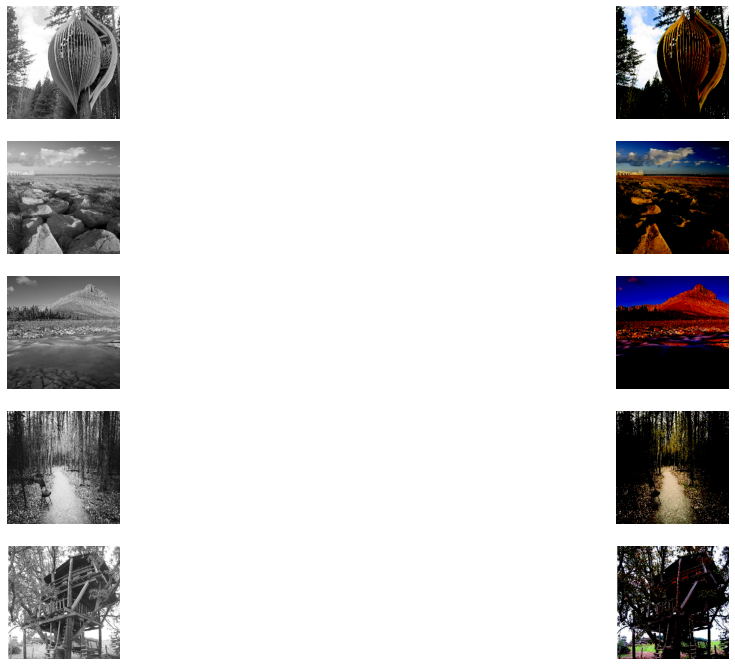

In [ ]:
plot(X,Y) # plotting 5 random images and its grayscale

In [ ]:
#discriminator
def discriminator(shape=(256,256,3)):
  init = tf.keras.initializers.RandomNormal(stddev=0.02)

  src_image = tf.keras.layers.Input(shape=(256,256,1))
  tar_image = tf.keras.layers.Input(shape=shape)

  merged = tf.keras.layers.Concatenate()([src_image, tar_image])

  #C64
  d = tf.keras.layers.Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
  d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)

  #C128
  d = tf.keras.layers.Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = tf.keras.layers.BatchNormalization()(d)
  d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)

  #C256
  d = tf.keras.layers.Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = tf.keras.layers.BatchNormalization()(d)
  d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)

  #C512
  d = tf.keras.layers.Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = tf.keras.layers.BatchNormalization()(d)
  d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)

  #second last layer
  d = tf.keras.layers.Conv2D(512, (4,4), strides=(1,1), padding='same', kernel_initializer=init)(d)
  d = tf.keras.layers.BatchNormalization()(d)
  d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)

  #patch output
  d = tf.keras.layers.Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
  patch = tf.keras.layers.Activation('sigmoid')(d)

  #define model
  model = tf.keras.models.Model([src_image, tar_image], patch)

  #optimiser
  opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)

  #compiling the model
  model.compile(optimizer=opt, loss='binary_crossentropy', loss_weights=0.5)

  return model

In [ ]:
# encoder-decoder blocks

def encoder_block(input, filters, batch_norm=True):
  #weights initializer
  init = tf.keras.initializers.RandomNormal(stddev=0.02)
  #Conv layer
  e = tf.keras.layers.Conv2D(filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(input)
  #batch normalisation
  if batch_norm:
    e = tf.keras.layers.BatchNormalization()(e, training=True)
  #Leaky ReLU activation
  e = tf.keras.layers.LeakyReLU(alpha=0.2)(e)

  return e

def decoder_block(input, skip_in, filters, dropout=True):
  #weight initializer
  init = tf.keras.initializers.RandomNormal(stddev=0.02)
  #upsampling layer
  d = tf.keras.layers.Conv2DTranspose(filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(input)
  #dropout layer
  if dropout:
    d = tf.keras.layers.Dropout(0.5)(d, training=True)
  #merge with skip connections
  d = tf.keras.layers.Concatenate()([d, skip_in])
  #relu activation
  d = tf.keras.layers.Activation('relu')(d)

  return d

In [ ]:
# generator
def generator(shape=(256,256,3)):
  init = tf.keras.initializers.RandomNormal(stddev=0.02)

  input_layer = tf.keras.layers.Input(shape=(256,256,1))
  #encoder model
  e1 = encoder_block(input_layer, 64, False)
  e2 = encoder_block(e1, 128)
  e3 = encoder_block(e2, 256)
  e4 = encoder_block(e3, 512)
  e5 = encoder_block(e4, 512)
  e6 = encoder_block(e5, 512)
  e7 = encoder_block(e6, 512)
  #bottleneck layer
  b = tf.keras.layers.Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
  b = tf.keras.layers.Activation('relu')(b)
  #decoder layer
  d1 = decoder_block(b, e7, 512)
  d2 = decoder_block(d1, e6, 512)
  d3 = decoder_block(d2, e5, 512)
  d4 = decoder_block(d3, e4, 512, dropout=False)
  d5 = decoder_block(d4, e3, 256, dropout=False)
  d6 = decoder_block(d5, e2, 128, dropout=False)
  d7 = decoder_block(d6, e1, 64, dropout=False)
  #output
  output = tf.keras.layers.Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
  out_image = tf.keras.layers.Activation('tanh')(output)
  #define model
  model = tf.keras.models.Model(input_layer, out_image)

  return model

In [ ]:
#GAN
def gan(gen_model, dis_model, shape=(256,256,3)):
  dis_model.trainable = False
  src = tf.keras.layers.Input(shape=(256,256,1))
  gen_out = gen_model(src)
  dis_out = dis_model([src, gen_out])

  model = tf.keras.models.Model(src, [dis_out, gen_out])
  #compile
  opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
  model.compile(optimizer=opt, loss=['binary_crossentropy', 'mae'], loss_weights=[1,100])

  return model

In [ ]:
from matplotlib import pyplot
#ploting results and storing model after every 5 epochs
def summarize_performance(step, g_model, dataset, n_samples=3):
	# select a sample of input images
	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
	# generate a batch of fake samples
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	# scale all pixels from [-1,1] to [0,1]
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	# plot real source images
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realA[i,:,:,0],cmap='gray')
	# plot generated target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_fakeB[i])
	# plot real target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realB[i])
	# save plot to file
	filename1 = 'plot_%06d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	# save the generator model
	filename2 = 'model_%06d.h5' % (step+21)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

In [ ]:
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = np.zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

In [ ]:
def generate_real_samples(dataset, n_samples, patch_shape):
	# unpack dataset
	trainA, trainB = dataset  #X,Y
	# choose random instances
	ix = np.random.randint(0, trainA.shape[0], n_samples)
	# retrieve selected images
	X1, X2 = trainA[ix], trainB[ix]
	# generate 'real' class labels (1)
	y = np.ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

In [ ]:
# parameters
epochs = 20
batch_size = 1
steps = int(X.shape[0]/batch_size)

In [ ]:
#training

def train(dis_model, gen_model, gan_model, epochs=100, batch_size=1):
  n_patch = dis_model.output_shape[1]
  for i in range(epochs):
    for j in range(steps):
      X_real_src = X[j*(batch_size):(j+1)*batch_size]
      X_real_target = Y[j*(batch_size):(j+1)*batch_size]
      y_real = np.ones((batch_size, n_patch, n_patch)) 

      X_fake = gen_model(X_real_src)
      y_fake = np.zeros((batch_size, n_patch, n_patch))

      d_loss1 = dis_model.train_on_batch([X_real_src, X_real_target], y_real)
      d_loss2 = dis_model.train_on_batch([X_real_src, X_fake], y_fake)

      g_loss, _, _ = gan_model.train_on_batch(X_real_src, [y_real, X_real_target])

      print('>%d, %d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, j+1, d_loss1, d_loss2, g_loss))
    
    if i%5 == 0:
      summarize_performance(i, gen_model, [X,Y]) 





In [ ]:
image_shape = (256,256,3)

dis = discriminator(image_shape)
gen = generator(image_shape)

gan_model = gan(gen, dis, image_shape)

In [ ]:
train(dis, gen, gan_model, 50, batch_size)

Streaming output truncated to the last 5000 lines.
>14, 872, d1[0.000] d2[0.000] g[6.033]
>14, 873, d1[0.000] d2[0.000] g[2.608]
>14, 874, d1[0.000] d2[0.000] g[8.804]
>14, 875, d1[0.000] d2[0.000] g[4.769]
>14, 876, d1[0.000] d2[0.000] g[2.913]
>14, 877, d1[0.000] d2[0.000] g[7.942]
>14, 878, d1[0.000] d2[0.000] g[5.938]
>14, 879, d1[0.000] d2[0.000] g[6.241]
>14, 880, d1[0.000] d2[0.000] g[6.659]
>14, 881, d1[0.000] d2[0.000] g[9.428]
>14, 882, d1[0.000] d2[0.000] g[16.604]
>14, 883, d1[0.000] d2[0.000] g[9.031]
>14, 884, d1[0.000] d2[0.000] g[23.022]
>14, 885, d1[0.000] d2[0.000] g[6.924]
>14, 886, d1[0.000] d2[0.000] g[9.592]
>14, 887, d1[0.000] d2[0.000] g[8.306]
>14, 888, d1[0.000] d2[0.000] g[9.065]
>14, 889, d1[0.000] d2[0.000] g[5.931]
>14, 890, d1[0.000] d2[0.000] g[10.157]
>14, 891, d1[0.000] d2[0.000] g[11.360]
>14, 892, d1[0.000] d2[0.000] g[9.933]
>14, 893, d1[0.000] d2[0.000] g[9.814]
>14, 894, d1[0.000] d2[0.000] g[11.151]
>14, 895, d1[0.000] d2[0.000] g[13.185]
>14, 89

In [ ]:
gen = tf.keras.models.load_model('model_000066.h5')

In [ ]:
# function to load test images

import tensorflow as tf
import os
import numpy as np

def load_images(path, size=(256,256)):
  files = os.listdir(path)
  X = []
  # y = []

  for fn in files:
    destination = os.path.join(path, fn)
    image = tf.keras.preprocessing.image.load_img(destination, target_size = size)
    image = tf.keras.preprocessing.image.img_to_array(image)
    source = image
    # source, target = image[:, :256], image[:, 256:]

    X.append(source)
    if len(X)>2499:  #number increased
      break
    # y.append(target)
  
  X = np.array(X)
  # y = np.array(y)
 
  #normalizing
  X = (X-127.5)/127.5
  # y = (y-127.5)/127.5
  # print(f'Shape of the source images {X.shape}\nShape of the target images {y.shape}')
  print(f'Shape of the source images {X.shape} ')
  # return X, y
  return X

In [ ]:
path_train = '/content/images/val_large'
X_train = load_images(path_train)

Shape of the source images (2500, 256, 256, 3) 


In [ ]:
Y_test = X_train[2000:2500] # test data

In [ ]:
X_test = grayscale(X_train[2000:2500])

In [ ]:
out = gen.predict(X_test[1:2])
out = out[0]
np.shape(out)


(256, 256, 3)

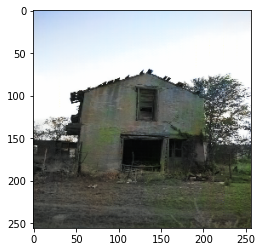

In [ ]:
plt.imshow((out+1)/2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


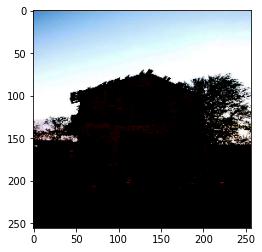

In [ ]:
plt.imshow(Y_test[1])

In [ ]:
def plot_test_data(n_images): # plotting 5 random impages from test data and corresponfing generated outputs

  indices = np.random.choice(range(X_test.shape[0]), n_images)

  test_set_src = X_test[indices]
  test_set_tar = Y_test[indices]
  out = gen.predict(test_set_src)

  plt.figure(figsize=(20,12))

  for i in range(n_images):
    plt.subplot(n_images, 3, 3*i+1)
    img_src = (test_set_src[i]+1)/2
    plt.imshow(img_src[:,:,0],cmap='gray')
    plt.title('source image')
    plt.axis('off')

    plt.subplot(n_images, 3, 3*i+2)
    tar_img = (test_set_tar[i]+1)/2
    plt.imshow(tar_img)
    plt.title('target image')
    plt.axis('off')

    plt.subplot(n_images, 3, 3*i+3)
    out_img = (out[i]+1)/2
    plt.imshow(out_img)
    plt.title('generated output image')
    plt.axis('off')


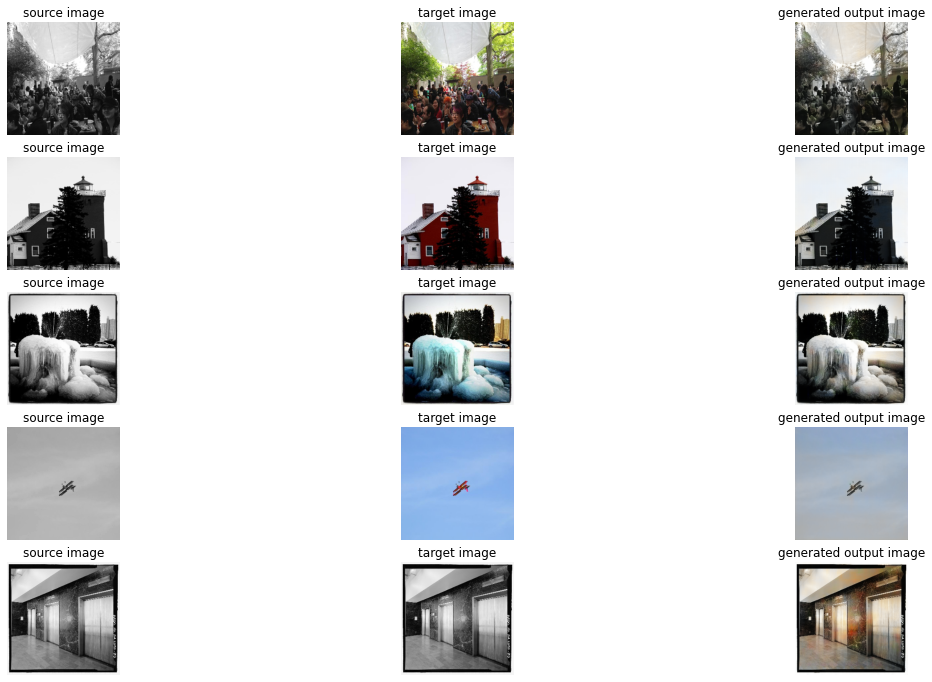

In [ ]:
n_images = 5
plot_test_data(n_images)

In [ ]:
# Importing all necessary libraries for capturing video and extracting frames
import cv2 
import os 

# Read the video from specified path 
cam = cv2.VideoCapture("1.mkv") 

try: 
	
	# creating a folder named data 
	if not os.path.exists('data'): 
		os.makedirs('data') 

# if not created then raise error 
except OSError: 
	print ('Error: Creating directory of data') 

# frame 
currentframe = 0

while(True): 
	
	# reading from frame 
	ret,frame = cam.read() 

	if ret: 
		# if video is still left continue creating images 
		name = './data/frame' + str(currentframe) + '.jpg'
		print ('Creating...' + name) 

		# writing the extracted images 
		cv2.imwrite(name, frame) 

		# increasing counter so that it will 
		# show how many frames are created 
		currentframe += 1
	else: 
		break

# Release all space and windows once done 
cam.release() 
cv2.destroyAllWindows() 


Streaming output truncated to the last 5000 lines.
Creating..../data/frame1347.jpg
Creating..../data/frame1348.jpg
Creating..../data/frame1349.jpg
Creating..../data/frame1350.jpg
Creating..../data/frame1351.jpg
Creating..../data/frame1352.jpg
Creating..../data/frame1353.jpg
Creating..../data/frame1354.jpg
Creating..../data/frame1355.jpg
Creating..../data/frame1356.jpg
Creating..../data/frame1357.jpg
Creating..../data/frame1358.jpg
Creating..../data/frame1359.jpg
Creating..../data/frame1360.jpg
Creating..../data/frame1361.jpg
Creating..../data/frame1362.jpg
Creating..../data/frame1363.jpg
Creating..../data/frame1364.jpg
Creating..../data/frame1365.jpg
Creating..../data/frame1366.jpg
Creating..../data/frame1367.jpg
Creating..../data/frame1368.jpg
Creating..../data/frame1369.jpg
Creating..../data/frame1370.jpg
Creating..../data/frame1371.jpg
Creating..../data/frame1372.jpg
Creating..../data/frame1373.jpg
Creating..../data/frame1374.jpg
Creating..../data/frame1375.jpg
Creating..../data/fra

In [ ]:
# function to load frames as arrays

import tensorflow as tf
import os
import numpy as np

def load_video_images(path, size=(256,256)):
  files = os.listdir(path)
  files.sort()
  X = []
  # y = []

  for fn in files:
    destination = os.path.join(path, fn)
    image = tf.keras.preprocessing.image.load_img(destination, target_size = size)
    image = tf.keras.preprocessing.image.img_to_array(image)
    source = image
    # source, target = image[:, :256], image[:, 256:]

    X.append(source)
    if len(X)>2499:
      break
    # y.append(target)
  
  X = np.array(X)
  # y = np.array(y)
 
  #normalizing
  X = (X-127.5)/127.5
  # y = (y-127.5)/127.5
  # print(f'Shape of the source images {X.shape}\nShape of the target images {y.shape}')
  print(f'Shape of the source images {X.shape} ')
  # return X, y
  return X

In [ ]:
path_train = '/content/images'
X_train = load_video_images(path_train)

In [ ]:
X_video = grayscale(X_train)

In [ ]:
X_video = np.rot90(X_video)
X_video = np.rot90(X_video)

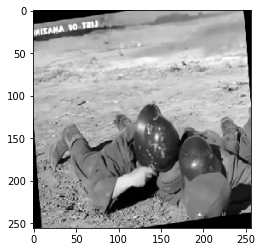

In [ ]:
plt.imshow(X_video[9,:,:,0],cmap='gray')

In [ ]:
video_out = gen.predict(X_video)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


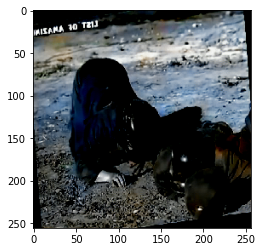

In [ ]:
plt.imshow(img[100])

In [ ]:
import glob
for file_name in glob.glob("*.png"):
  os.remove(file_name)

In [ ]:
import subprocess

#function to rejoin generated frames and merge them
def generate_video(img):
    for i in range(len(img)):
        plt.imshow(img[i])
        plt.savefig( "/content/data/file%04d.png" % i)

    os.chdir("/content/data")
    subprocess.call([
        'ffmpeg', '-framerate', '8', '-i', 'file%04d.png', '-r', '30', '-pix_fmt', 'yuv420p',
        '1.mp4'
    ])
    for file_name in glob.glob("*.png"):
        os.remove(file_name)
generate_video(img)

In [ ]:
#function to play the video chalie chalpin movie clip
from IPython.display import HTML
from base64 import b64encode
mp4 = open('/content/data/1.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)